In [1]:
from scipy.integrate import ode
from tqdm import tqdm

%pylab inline
import numpy as np

def solve(f, Xs, Y0, with_h = 1., max_iter = 1e5):
    X0, XF = Xs
    r = ode(f)
    r.set_integrator('dopri5')
    r.set_initial_value(Y0, X0)

    dt = with_h
    Xs = []
    Ys = []
    
    length = min((XF - X0)/dt, max_iter)
    for i in tqdm(range(int(length))):
        if not r.successful():
            break

        r.integrate(r.t + dt)
        Xs.append(r.t)
        Ys.append(r.y)
    return Xs, Ys

Populating the interactive namespace from numpy and matplotlib


In [52]:
g, l, k, m = [10., 7., 40., 2.]
R = 0.9

X0 = 0
XF = 10
L_0 = 1
n_balls = (4, 5)
EQ = np.array([[[x, 0., y, 0.] for x in range(n_balls[0])] for y in range(n_balls[1])])
neighbours = [(0, -1), (0, 1), (-1, 0), (1, 0)]

In [53]:
neighbours

[(0, -1), (0, 1), (-1, 0), (1, 0)]

In [54]:
Y0 = np.copy(EQ)
Y0[1,1] = [1.2, 0., 1.2, 0.]
Y0 = Y0.ravel()

In [55]:
def f(t, Ys):
    nYs = np.zeros_like(EQ)
    Ys = Ys.reshape(EQ.shape)
    for x in range(1, n_balls[0]-1):
        for y in range(1, n_balls[1]-1):
            x0, dx0, y0, dy0 = Ys[y, x]
            ddx0 = -R*dx0
            ddy0 = -g - R*dx0
            for i in neighbours:
                x1, dx1, y1, dy1 = Ys[i[0] + y, i[1] + x]
                delta_x = (x1 - x0)
                delta_y = (y1 - y0)
                D = np.sqrt(delta_x**2 + delta_y**2)
                F = k*(D - L_0)
                F_x = F*delta_x/D
                F_y = F*delta_y/D
                ddx0 += F_x/m
                ddy0 += F_y/m
            nYs[y, x] = [dx0, ddx0, dy0, ddy0]
    return nYs.ravel()

In [56]:
Xs, Ys = solve(f, (X0, XF), Y0, with_h = 1e-2)

In [57]:
YsR = np.array(Ys).reshape((len(Ys),) + EQ.shape)

In [58]:
YsR.shape

(1000, 5, 4, 4)

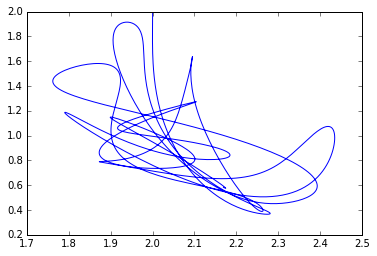

In [59]:
def plot_trajectory(Ys):
    Xs = Ys[:, 2, 2, 0]
    Ys = Ys[:, 2, 2, 2]
    plot(Xs, Ys)
    
plot_trajectory(YsR)

In [60]:
def anim(Ys, fps = 10, d=5):
    import matplotlib.pyplot as plt
    from matplotlib import animation
    import numpy as np

    from embed_gif import from_anim

    fig = plt.figure()
    fig.set_dpi(100)
    fig.set_size_inches(7, 6.5)

    ax = plt.axes(xlim=(-2, 7), ylim=(-2, 7))
    patches = [[plt.Circle((-5, 5), 0.05, fc='y') for x in range(n_balls[0])] for y in range(n_balls[1])]
    forces = [[ax.plot([0], [0], '-', lw=1)[0] for x in range(n_balls[0])] for y in range(n_balls[1])]
    springs_h = [[ax.plot([0], [0], '--', lw=.5, c='g')[0] for x in range(n_balls[0]-1)] for y in range(n_balls[1])]
    springs_v = [[ax.plot([0], [0], '--', lw=.5, c='g')[0] for x in range(n_balls[0])] for y in range(n_balls[1]-1)]
   
    xs = Ys[:, :, :, 0]
    ys = Ys[:, :, :, 2]
    fxs = Ys[:, :, :, 1]
    fys = Ys[:, :, :, 3]
    base_l = l/2.
    
    nitems = Ys.shape[0]
    nframes = fps*d
    
    scale = lambda i: int(i/nframes*nitems)

    flatten = lambda a: [x for y in a for x in y]
    
    def init():
        for x in range(n_balls[0]):
            for y in range(n_balls[1]):
                patches[y][x].center = (EQ[y,x,0], EQ[y,x,2])
                ax.add_patch(patches[y][x])
        return flatten(patches)

    def animate(i):
        k = scale(i)
        cxs, cys = xs[k], ys[k]
        for x in range(n_balls[0]):
            for y in range(n_balls[1]):
                px, py = (cxs[y,x], cys[y,x])
                patches[y][x].center = (px, py)
                #forces[y][x].set_data([px, px - fxs[k, y, x]], [py, py - fys[k, y, x]])
        for x in range(n_balls[0]):
            for y in range(n_balls[1]-1):
                px, py = (Ys[k, y, x, 0], Ys[k, y, x, 2])
                npx, npy = (Ys[k, y+1, x, 0], Ys[k, y+1, x, 2])
                springs_v[y][x].set_data([px, npx], [py, npy])
        for x in range(n_balls[0]-1):
            for y in range(n_balls[1]):
                px, py = (Ys[k, y, x, 0], Ys[k, y, x, 2])
                npx, npy = (Ys[k, y, x+1, 0], Ys[k, y, x+1, 2])
                springs_h[y][x].set_data([px, npx], [py, npy])
        return flatten(patches) + flatten(forces) + flatten(springs_v) + flatten(springs_h)

    anim = animation.FuncAnimation(fig, animate, 
                                   init_func=init, frames=nframes, interval=1/fps*1000., blit=True)
    return from_anim(anim)

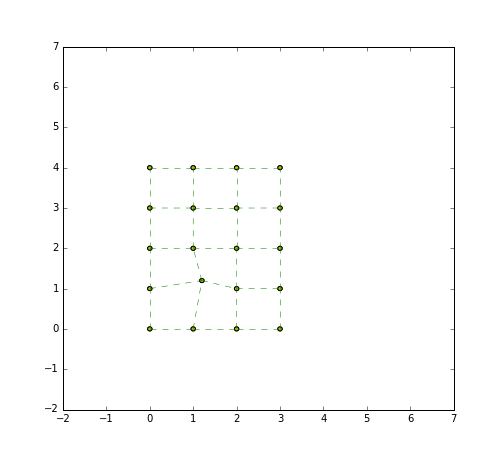

In [61]:
anim(YsR, d = 300, fps = 1)